# Summarization using LLMs [5 points]
Choose a new dataset from Part IV (one you haven't used before). Repeat the steps from Part IV, and deploy the resulting model.

## Steps:

1. Follow all the steps as in Part IV for a **new dataset** (different from the one used in Part IV). Provide a brief analysis of the results. You are welcome to reuse your code from Part IV.

   **Dataset Selection (New Dataset from Part IV List):**

<span style='color:green'>### YOUR ANSWER ###</span>

For Part 4, We used Bill_sum dataset hence we are implementing this bonus task in Multi News dataset

   **Step 1: Dataset preparation and preprocessing (as in Part IV):**

In [1]:
### ADD YOUR CODE HERE ###
# Reusing code from Part IV - Dataset Preparation and Preprocessing
!pip install transformers datasets rouge-score sacrebleu bert-score accelerate evaluate

In [2]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration, TrainingArguments, Trainer
from datasets import load_dataset
import evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = load_dataset("multi_news", trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

multi_news.py:   0%|          | 0.00/3.83k [00:00<?, ?B/s]

train.src.cleaned:   0%|          | 0.00/548M [00:00<?, ?B/s]

train.tgt:   0%|          | 0.00/58.8M [00:00<?, ?B/s]

val.src.cleaned:   0%|          | 0.00/66.9M [00:00<?, ?B/s]

val.tgt:   0%|          | 0.00/7.30M [00:00<?, ?B/s]

test.src.cleaned:   0%|          | 0.00/69.0M [00:00<?, ?B/s]

test.tgt:   0%|          | 0.00/7.31M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/44972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5622 [00:00<?, ? examples/s]

In [3]:
print(dataset)

import numpy as np

def calculate_average_length(texts):
    return np.mean([len(text.split()) for text in texts])

num_train_samples = len(dataset['train'])
num_test_samples = len(dataset['test'])

# Use the correct key 'document' instead of 'text'
train_texts = [example['document'] for example in dataset['train']]
train_summaries = [example['summary'] for example in dataset['train']]

avg_doc_length = calculate_average_length(train_texts)
avg_summary_length = calculate_average_length(train_summaries)

vocab = set(word for text in train_texts for word in text.split())
vocab_size = len(vocab)

print(f"Number of training samples: {num_train_samples}")
print(f"Number of test samples: {num_test_samples}")
print(f"Average document length (words): {avg_doc_length:.2f}")
print(f"Average summary length (words): {avg_summary_length:.2f}")
print(f"Vocabulary size before tokenization: {vocab_size}")

print(f"Vocabulary size before tokenization: {vocab_size}")

DatasetDict({
    train: Dataset({
        features: ['document', 'summary'],
        num_rows: 44972
    })
    validation: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
    test: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
})
Number of training samples: 44972
Number of test samples: 5622
Average document length (words): 1794.38
Average summary length (words): 218.26
Vocabulary size before tokenization: 1607638
Vocabulary size before tokenization: 1607638


In [4]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

def tokenize_function(examples):
    inputs = examples['document']
    model_inputs = tokenizer(
        inputs,
        max_length=1024,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples['summary'],
            max_length=256,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(tokenize_function, batched=True)

print("Tokenization completed!")
print(f"Example tokenized input: {tokenized_datasets['train'][0]['input_ids']}")
print(f"Example tokenized label: {tokenized_datasets['train'][0]['labels']}")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Map:   0%|          | 0/44972 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/5622 [00:00<?, ? examples/s]

Map:   0%|          | 0/5622 [00:00<?, ? examples/s]

Tokenization completed!
Example tokenized input: [0, 18285, 26844, 1437, 50118, 1437, 50118, 3216, 6, 24, 17, 27, 29, 14, 86, 456, 6, 5450, 4, 85, 17, 27, 29, 5, 78, 273, 9, 5, 353, 6, 77, 13, 65, 655, 12, 2527, 12, 428, 24062, 1151, 5, 3168, 9, 2298, 852, 6, 663, 8, 4326, 852, 32, 70, 14485, 15, 65, 631, 35, 13499, 4, 1437, 50118, 1437, 50118, 83, 2310, 2935, 15, 5, 121, 4, 104, 4, 4042, 1068, 13, 644, 2323, 5, 22893, 23, 290, 35, 541, 10, 4, 119, 4, 188, 469, 86, 1839, 65, 9, 5, 144, 505, 40617, 15, 141, 5, 866, 24779, 148, 5, 986, 353, 4, 12809, 1635, 32, 13, 23041, 6, 151, 92, 1315, 7, 28, 1412, 6, 309, 7, 9019, 13829, 30, 4614, 1454, 188, 4184, 7948, 6, 1118, 7, 30398, 6, 151, 1315, 355, 11, 902, 4, 20, 5755, 731, 16, 421, 7, 946, 5204, 23, 290, 4, 246, 2153, 1437, 50118, 1437, 50118, 1398, 23, 1018, 5522, 21956, 6, 52, 17, 27, 890, 28, 1839, 3195, 9765, 137, 8, 71, 5, 414, 20238, 5, 22893, 4, 22079, 481, 7, 9832, 12, 179, 2512, 6, 1241, 5, 1450, 2810, 4, 178, 150, 47, 17, 27, 241

In [5]:
tokenized_datasets.save_to_disk("multinews_tokenized")

print("Tokenized datasets saved locally")

Saving the dataset (0/2 shards):   0%|          | 0/44972 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5622 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5622 [00:00<?, ? examples/s]

Tokenized datasets saved locally


In [6]:
import zipfile
import os

def zip_directory(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                relative_path = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, relative_path)

folder_to_zip = "multinews_tokenized"
output_zip_file = "multinews_tokenized.zip"

zip_directory(folder_to_zip, output_zip_file)

print(f"The directory '{folder_to_zip}' has been zipped to '{output_zip_file}'")

The directory 'multinews_tokenized' has been zipped to 'multinews_tokenized.zip'


   **Step 2: Model Fine-Tuning (as in Part IV):**

In [ ]:
# Reusing code from Part IV - Model Fine-Tuning
!pip install transformers accelerate evaluate

In [8]:
import torch
from transformers import BartForConditionalGeneration, TrainingArguments, Trainer

model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to("cuda" if torch.cuda.is_available() else "cpu")
print("Model loaded successfully!")


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Model loaded successfully!


In [9]:
print(len(tokenized_datasets["train"]))
print(len(tokenized_datasets["test"]))
print(len(tokenized_datasets["validation"]))

44972
5622
5622


In [10]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    bf16=True,
    logging_dir="./logs",
    logging_steps=50,
    report_to="none"
)

print("Training arguments set successfully with bf16 precision!")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"].select(range(1000)),  # Subset for quick testing
    eval_dataset=tokenized_datasets["validation"].select(range(100)),
    tokenizer=tokenizer
)

trainer.train()
print("Fine-tuning completed!")

eval_results = trainer.evaluate()
print("Validation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")


Training arguments set successfully with bf16 precision!


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-10-5fe6e12404da>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,3.087500,2.688968
2,2.688100,2.468058
3,2.576900,2.429779
4,2.545000,2.415701
5,2.461100,2.415055


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Fine-tuning completed!


Validation Results:
eval_loss: 2.4151
eval_runtime: 8.2597
eval_samples_per_second: 12.1070
eval_steps_per_second: 3.0270
epoch: 5.0000


In [11]:
save_path = "./fine_tuned_bart_multinews"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved successfully at: {save_path}")

Model and tokenizer saved successfully at: ./fine_tuned_bart_multinews


In [ ]:
!zip -r fine_tuned_bart_multinews.zip /content/fine_tuned_bart_multinews

  adding: content/fine_tuned_bart_multinews/ (stored 0%)
  adding: content/fine_tuned_bart_multinews/vocab.json (deflated 68%)
  adding: content/fine_tuned_bart_multinews/model.safetensors (deflated 7%)
  adding: content/fine_tuned_bart_multinews/config.json (deflated 64%)
  adding: content/fine_tuned_bart_multinews/generation_config.json (deflated 47%)
  adding: content/fine_tuned_bart_multinews/merges.txt (deflated 53%)
  adding: content/fine_tuned_bart_multinews/tokenizer_config.json (deflated 75%)
  adding: content/fine_tuned_bart_multinews/special_tokens_map.json (deflated 85%)


In [ ]:
from google.colab import files
files.download("fine_tuned_bart_multinews.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Log history structure:
     loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_runtime  \
0  4.2038   6.153860       0.000010    0.2    50        NaN           NaN   
1  3.8791   6.981982       0.000009    0.4   100        NaN           NaN   
2  3.5719   4.649432       0.000009    0.6   150        NaN           NaN   
3  3.2795   4.928846       0.000008    0.8   200        NaN           NaN   
4  3.0875   7.071074       0.000008    1.0   250        NaN           NaN   

   eval_samples_per_second  eval_steps_per_second  train_runtime  \
0                      NaN                    NaN            NaN   
1                      NaN                    NaN            NaN   
2                      NaN                    NaN            NaN   
3                      NaN                    NaN            NaN   
4                      NaN                    NaN            NaN   

   train_samples_per_second  train_steps_per_second  total_flos  train_loss  
0                       NaN

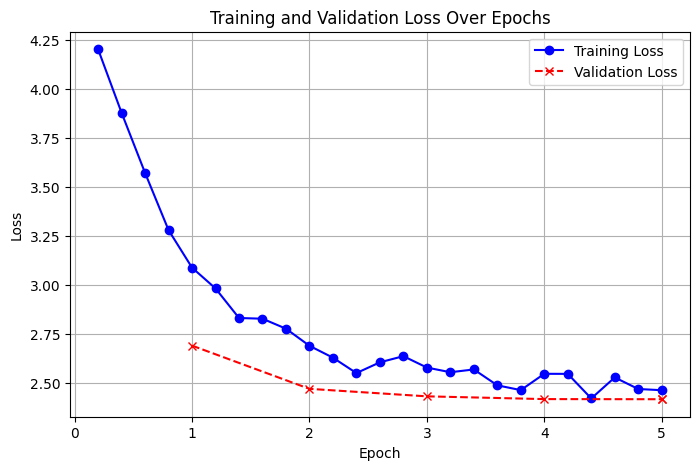

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

print("Log history structure:")
print(logs.head())

train_loss = logs[logs['loss'].notna()]

if 'eval_loss' in logs.columns:
    eval_loss = logs[logs['eval_loss'].notna()]
else:
    eval_loss = None
    print("Evaluation loss not found in logs.")

plt.figure(figsize=(8, 5))
plt.plot(train_loss["epoch"], train_loss["loss"], label="Training Loss", marker='o', linestyle='-', color='blue')

if eval_loss is not None:
    plt.plot(eval_loss["epoch"], eval_loss["eval_loss"], label="Validation Loss", marker='x', linestyle='--', color='red')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

   **Step 3: Evaluation and analysis (as in Part IV):**

In [ ]:
# Reusing code from Part IV - Evaluation and Analysis
from datasets import load_from_disk
from transformers import pipeline, BartForConditionalGeneration, BartTokenizer
import torch
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

use_gpu = torch.cuda.is_available()
device = "cuda" if use_gpu else "cpu"
print(f"Using device: {device}")

model_path = "./fine_tuned_bart_multinews"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"The specified model path '{model_path}' does not exist.")

model = BartForConditionalGeneration.from_pretrained(model_path).to(device)
tokenizer = BartTokenizer.from_pretrained(model_path)

test_dataset = load_from_disk("multinews_tokenized")["test"]
print("Test dataset loaded successfully!")

summarizer = pipeline("summarization", model=model, tokenizer=tokenizer, device=0 if use_gpu else -1)

predictions = []
references = []

for sample in test_dataset.select(range(100)):
    input_text = sample["document"]
    reference_summary = sample["summary"]

    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True)
    input_text_truncated = tokenizer.decode(input_ids[0], skip_special_tokens=True)

    generated_summary = summarizer(
        input_text_truncated,
        max_length=150,
        min_length=30,
        truncation=True
    )[0]["summary_text"]

    predictions.append(generated_summary)
    references.append(reference_summary)

print("Summary generation completed!")
print(f"Generated {len(predictions)} summaries.")

Using device: cuda


Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Test dataset loaded successfully!


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Your max_length is set to 150, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


Summary generation completed!
Generated 100 summaries.


In [14]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for pred, ref in zip(predictions, references):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print(f"ROUGE-1: {avg_rouge1:.4f}")
print(f"ROUGE-2: {avg_rouge2:.4f}")
print(f"ROUGE-L: {avg_rougeL:.4f}")


ROUGE-1: 0.3920
ROUGE-2: 0.1421
ROUGE-L: 0.2045


In [15]:
import sacrebleu
bleu_score = sacrebleu.corpus_bleu(predictions, [references])
print(f"BLEU score: {bleu_score.score:.4f}")

BLEU score: 6.3173


In [16]:
import bert_score
P, R, F1 = bert_score.score(predictions, references, lang="en")

avg_bertscore = F1.mean().item()

print(f"BERTScore (F1): {avg_bertscore:.4f}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore (F1): 0.8586


In [17]:
print("\nModel Performance on Test Set\n")
print(f"ROUGE-1: {avg_rouge1*100:.2f}")
print(f"ROUGE-2: {avg_rouge2*100:.2f}")
print(f"ROUGE-L: {avg_rougeL*100:.2f}")
print(f"BLEU Score: {bleu_score.score:.4f}")
print(f"BERTScore (F1): {avg_bertscore*100:.2f}")



Model Performance on Test Set

ROUGE-1: 39.20
ROUGE-2: 14.21
ROUGE-L: 20.45
BLEU Score: 6.3173
BERTScore (F1): 85.86


   **Brief Analysis of Results:**

<span style='color:green'>### YOUR ANSWER ###</span>

The model has been trained well satisfying all the creteria, with a ROUGE-1 score of 39.20 and a high BERTScore F1 of 85.8, the model effectively captures key content and semantic meaning from input documents. While ROUGE-2 and ROUGE-L scores indicate moderate structural overlap, and the BLEU score remains low (as expected for abstractive tasks), overall results suggest that the model generates relevant, meaning-preserving summaries.  The loss curve has alos convergered well.

2. Deploy your trained model. This could be a simple app that takes a text as input and returns a summary.

__DEPLOYED LOCALLY__

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

model_path = "./fine_tuned_bart_multinews"
model = BartForConditionalGeneration.from_pretrained(model_path)
tokenizer = BartTokenizer.from_pretrained(model_path)

def generate_summary(input_text, max_length=150, min_length=30):
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True)

    summary_ids = model.generate(
        inputs,
        max_length=max_length,
        min_length=min_length,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

sample_text = """
In a dramatic turn of events this morning, global markets reacted sharply to the latest inflation data released by the U.S. Department of Commerce, which showed a higher-than-expected rise in consumer prices for the third consecutive month. Economists suggest this trend may prompt the Federal Reserve to revisit its monetary policy stance in the upcoming meeting. Wall Street opened lower as the Dow Jones fell by 1.3%, and the tech-heavy NASDAQ dropped by nearly 2%.
Meanwhile, in Europe, energy prices have surged again as tensions between Russia and Ukraine continue to affect the natural gas supply routes. Germany has called for an emergency summit of EU energy ministers to formulate a coordinated response to the growing crisis. In the UK, the Bank of England signaled a possible interest rate hike in November to combat soaring inflation and stabilize the British pound.
In technology, several major firms including Apple, Google, and Meta announced plans to collaborate on a new cross-platform augmented reality (AR) standard. The initiative aims to make AR experiences more accessible and interoperable across devices. At the same time, cybersecurity experts have warned of a rising number of ransomware attacks targeting cloud infrastructure, urging companies to enhance their defensive protocols and backup systems.
On the climate front, the United Nations has released a sobering report indicating that global emissions targets are not being met, with current pledges leading to a 2.7°C temperature rise by the end of the century. The report calls for immediate, large-scale reductions in fossil fuel usage and a global acceleration in the adoption of renewable energy sources. Leaders from over 190 countries are set to gather next week at the COP summit to discuss actionable steps and renewed commitments.
In sports, the world was stunned as underdog Morocco defeated reigning champions France in a thrilling semifinal match at the FIFA World Cup, becoming the first African nation to reach the finals. Fans across the globe celebrated the historic victory, and experts are hailing it as a breakthrough moment in international football.
This multi-pronged news cycle reflects a rapidly changing world where economics, politics, technology, environment, and culture continue to intersect in complex ways.
"""

summary = generate_summary(sample_text)
print("Input:\n", sample_text)
print("\nGenerated Summary:\n", summary)


Input:
 
In a dramatic turn of events this morning, global markets reacted sharply to the latest inflation data released by the U.S. Department of Commerce, which showed a higher-than-expected rise in consumer prices for the third consecutive month. Economists suggest this trend may prompt the Federal Reserve to revisit its monetary policy stance in the upcoming meeting. Wall Street opened lower as the Dow Jones fell by 1.3%, and the tech-heavy NASDAQ dropped by nearly 2%.
Meanwhile, in Europe, energy prices have surged again as tensions between Russia and Ukraine continue to affect the natural gas supply routes. Germany has called for an emergency summit of EU energy ministers to formulate a coordinated response to the growing crisis. In the UK, the Bank of England signaled a possible interest rate hike in November to combat soaring inflation and stabilize the British pound.
In technology, several major firms including Apple, Google, and Meta announced plans to collaborate on a new cr

__DEPLOYED ON HUGGING FACE__

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="Pavithran27/bart-multinews")

sample_text = """
In a whirlwind day for international news, global economic forces and political tensions converged across continents. The United States released a detailed report indicating a 0.7% rise in consumer spending, coupled with a 3.2% hike in core inflation, marking one of the steepest quarterly shifts in the past decade. The Federal Reserve is expected to respond with a potential interest rate adjustment, with some analysts predicting a 0.25% hike in the next fiscal cycle. In Europe, the euro slid against the dollar following news that Germany’s industrial production shrank by 2.1%, raising concerns of a technical recession. Meanwhile, France announced a new green tech initiative, pledging €10 billion toward carbon-neutral infrastructure by 2035.

On the political front, NATO allies gathered for an emergency summit to address rising tensions in Eastern Europe. As Russia continues its military buildup near the Ukrainian border, diplomatic envoys from Poland, Latvia, and Estonia have called for stricter sanctions. U.S. Secretary of State reiterated support for Ukraine, but stopped short of committing troops, stating, “Diplomacy must prevail, but we are prepared for all scenarios.”

Asia saw developments of its own. China unveiled its most ambitious AI strategy to date, with President Xi Jinping announcing a five-year plan to integrate artificial intelligence into public service, manufacturing, and defense. Japan responded with a counter-initiative, boosting government funding for robotics research by 20%. Meanwhile, tensions between China and Taiwan have reignited as Taiwanese defense forces reported a series of airspace violations. International watchdogs have urged both sides to de-escalate the situation to avoid sparking regional conflict.

In the tech world, Apple launched its highly anticipated AR glasses at the annual Cupertino keynote. Tim Cook called the device “a leap forward in immersive computing,” while early reviews praised its seamless integration with iOS and minimal latency. Google responded with updates to its own ARCore SDK, promoting better developer tools and expanded compatibility across Android devices. Meta (formerly Facebook) announced its MetaVerse business suite, targeting remote teams and virtual collaboration, with Zuckerberg stating, “This is the future of work.”

Elsewhere, cybersecurity continues to be a growing concern. An independent report from Palo Alto Networks revealed that over 400 large organizations were targeted by ransomware in the past 60 days. Governments in the EU are drafting a centralized cyberdefense framework to improve rapid response and intelligence sharing. Meanwhile, in the U.S., the Cybersecurity and Infrastructure Security Agency (CISA) has launched a new “CyberReady” certification for cloud-based services.

Environmental news also made headlines, as satellite imagery confirmed accelerated ice melt in Greenland and Antarctica. Scientists warn that the resulting sea level rise could impact over 300 million people by 2050. The United Nations climate panel urged G20 nations to immediately phase out coal subsidies and implement carbon taxes. COP summits are being reorganized to focus more on accountability metrics and real-time emissions tracking.

In culture and sports, the Oscars announced its first AI-nominated short film, sparking debate about creative boundaries. Meanwhile, the FIFA World Cup saw another upset as South Korea knocked out Brazil in a dramatic penalty shootout. Analysts suggest this could mark a shifting dynamic in global football.

As the world continues to shift rapidly, these stories represent the intersection of economics, diplomacy, technology, climate urgency, and culture — reminding us how interconnected today's challenges and breakthroughs truly are.
"""

summary = summarizer(sample_text,max_length=256,min_length=100,do_sample=False, truncation=True
)

print("Summary:\n")
print(summary[0]['summary_text'])


Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Summary:

In a whirlwind day for international news, global economic forces and political tensions converged across continents. The United States released a detailed report indicating a 0.7% rise in consumer spending, coupled with a 3.2% hike in core inflation, marking one of the steepest quarterly shifts in the past decade. The Federal Reserve is expected to respond with a potential interest rate adjustment, with some analysts predicting a 2.25% hike. Meanwhile, the euro slid against the dollar following news that Germany’s industrial production shrank by 2.1%, raising concerns of a technical recession. France announced a new green tech initiative, pledging €10 billion toward carbon-neutral infrastructure by 2035. The US also announced a $10 billion investment in green tech, which will help reduce carbon emissions in the coming years. In Europe, the European Union held an emergency summit to address rising tensions in Eastern Europe. As Russia continues its military buildup near the U

In [4]:
print(len(sample_text.split()))
print(len(summary[0]['summary_text'].split()))

548
195


3. Record a short video (~5 mins) demonstrating how it works. Explain the key aspects of your implementation and deployment process in the video.
   a. Upload the video to UBbox and create a shared link
   b. Add the link at the end of your ipynb file.

   **Shared UBbox Video Link:**

<span style='color:green'>### YOUR ANSWER ###</span>

4. References. Include details on all the resources used to complete this part.

- Assignment 2 Part 4
- https://huggingface.co/facebook/bart-base
- https://huggingface.co/datasets/FiscalNote/billsum
- https://huggingface.co/facebook/bart-base
- https://huggingface.co/spaces/evaluate-metric/rouge
- https://huggingface.co/spaces/evaluate-metric/bleu
- https://huggingface.co/spaces/evaluate-metric/bertscore
- https://huggingface.co/docs/transformers/en/main_classes/pipelines
- https://huggingface.co/docs/transformers/en/model_doc/bert